# NLP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df_copom = pd.read_csv('df_copom_label_pt.csv')

In [3]:
df_copom.head(1)

,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,21,1998/01/28,1998/01/28,34.5,-3.5,cortar,minutes,sumáriopreços nível atividade agregados monetá...,3926.0,\nSumárioPreços e Nível de Atividade\nAgregado...,5066.0,dovish,cortar


In [4]:
df_copom.shape

(411, 13)

In [5]:
df_ = df_copom[(df_copom['type'] == 'statement')].copy()

In [6]:
df_.shape

(209, 13)

In [7]:
# df_ = df_[(df_['num_words'] <= 250)].copy()

In [8]:
# df_.shape

In [9]:
df_['num_words'].unique()

array([ 51.,  15.,  29.,  23.,  17.,   2.,  12.,  19.,  21.,  18.,  28.,
        22.,  55.,  25.,  26.,  14.,  16.,  20.,  34.,  44.,  42.,  31.,
        24.,  33.,  45.,  35.,  38.,  27.,  30.,  61.,  80.,  53.,  46.,
        60.,  58.,  40.,  43.,  52.,  36.,  69.,  73.,  78.,  49.,  32.,
        47.,  66.,  90.,  37.,  70., 218.,  57.,  41., 102., 109., 103.,
       122., 126., 125.,  48.,  86.,  99.,  98., 260., 405., 483., 450.,
       476., 350., 466., 416., 414., 481., 467., 499., 473., 540., 609.,
       620., 553., 602., 497., 528., 557., 508., 524., 549., 581., 522.,
       503., 458., 583., 550., 621., 701., 669., 733., 703., 596., 627.,
       653., 690., 533., 665., 643., 634., 518., 532., 520., 606., 469.])

<Axes: >

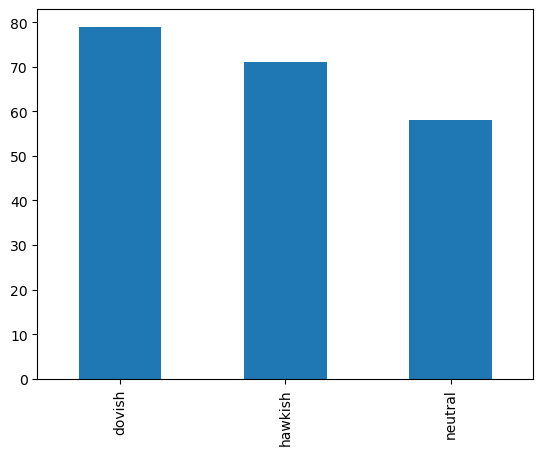

In [10]:
df_['label_hawk_dove'].value_counts().plot(kind='bar')

In [11]:
target_map = {'dovish': 0, 'hawkish': 1, 'neutral': 2}
df_['target'] = df_['label_hawk_dove'].map(target_map)

In [12]:
df = df_[['text', 'target']]
df.columns = ['sentence', 'label']

In [13]:
df.isnull().sum()

sentence    0
label       1
dtype: int64

In [14]:
df = df.dropna().copy()
df.shape

(208, 2)

In [15]:
df['label'] = df['label'].astype(int)

In [16]:
df.head()

,sentence,label
25,pese recentes trajetórias favoráveis taxas inf...,1
27,copom analisando eventos recentes prospectivos...,0
29,resultados recentes inflação mudaram significa...,0
31,"copom decidiu alterar meta taxa selic 17,0 % 1...",1
33,"copom decidiu manter meta taxa selic 16,50 % e...",2


In [17]:
df.to_csv('data_copom_transf_pt.csv', index=None)

#### Convert to dataset

In [18]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files='data_copom_transf_pt.csv')

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.67it/s]


Dataset csv downloaded and prepared to C:/Users/ftrav/.cache/huggingface/datasets/csv/default-5bf5fd7a6565d796/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.07it/s]


In [19]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 208
    })
})

#### Split test and train

In [20]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=2015)

In [21]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 145
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 63
    })
})

## Model

In [22]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification¶
# tokenizer = AutoTokenizer.from_pretrained("TiagoSanti/bert-base-portuguese-cased-02")
# model = AutoModelForSequenceClassification.from_pretrained("TiagoSanti/bert-base-portuguese-cased-02")

https://huggingface.co/TiagoSanti/bert-base-portuguese-cased-02

In [23]:
checkpoint = 'TiagoSanti/bert-base-portuguese-cased-02'

#### Tokenizer

In [87]:
from transformers import AutoTokenizer

In [96]:
max_length=512

In [97]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=True, max_length=max_length, truncation='longest_first')

In [98]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation='longest_first', padding=True)

In [99]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|                                                                         | 0/145 [00:00<?, ? examples/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [100]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 145
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63
    })
})

#### Training

In [29]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [74]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [31]:
from torchinfo import summary

In [32]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,881,792
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [33]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [34]:
training_args = TrainingArguments(
    output_dir='training_dir/pt/epoch5',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 64
)

In [35]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [36]:
trainer.train()

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.696387,0.730159,0.718523
2,No log,0.605407,0.746032,0.740459
3,No log,0.642802,0.746032,0.712233
4,No log,0.611234,0.777778,0.767058
5,No log,0.605023,0.777778,0.767058


TrainOutput(global_step=50, training_loss=0.7354808044433594, metrics={'train_runtime': 643.3725, 'train_samples_per_second': 1.127, 'train_steps_per_second': 0.078, 'total_flos': 190757227852800.0, 'train_loss': 0.7354808044433594, 'epoch': 5.0})

In [38]:
!dir training_dir\pt\epoch5

 Volume in drive C has no label.
 Volume Serial Number is 5AAA-7C2A

 Directory of C:\Users\ftrav\Documents\Insper_tcc\training_dir\pt\epoch5

07/02/2023  01:55 PM    <DIR>          .
07/02/2023  01:35 PM    <DIR>          ..
07/02/2023  01:47 PM    <DIR>          checkpoint-10
07/02/2023  01:49 PM    <DIR>          checkpoint-20
07/02/2023  01:51 PM    <DIR>          checkpoint-30
07/02/2023  01:53 PM    <DIR>          checkpoint-40
07/02/2023  01:55 PM    <DIR>          checkpoint-50
07/02/2023  01:45 PM    <DIR>          runs
               0 File(s)              0 bytes
               8 Dir(s)  38,488,719,360 bytes free


#### Test

In [41]:
from transformers import pipeline, AutoConfig

In [42]:
config = AutoConfig.from_pretrained(checkpoint)

In [101]:
savedmodel = pipeline('text-classification',
                      model='training_dir/pt/epoch5/checkpoint-50',
                      max_length=max_length,
                      tokenizer=tokenizer, 
                      config=config,
                      device=0,
                      framework="pt")

In [102]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 63
})

In [103]:
test_pred = savedmodel(split['test']['sentence'], batch_size=128, truncation="longest_first")

In [105]:
for i in range(len(split['test']['label'])):
    print (split['test']['label'][i], test_pred[i])

2 {'label': 'LABEL_2', 'score': 0.780500054359436}
0 {'label': 'LABEL_0', 'score': 0.9683125615119934}
0 {'label': 'LABEL_0', 'score': 0.9685774445533752}
2 {'label': 'LABEL_2', 'score': 0.8075130581855774}
1 {'label': 'LABEL_1', 'score': 0.9757391214370728}
1 {'label': 'LABEL_1', 'score': 0.9483247995376587}
0 {'label': 'LABEL_0', 'score': 0.94301438331604}
0 {'label': 'LABEL_0', 'score': 0.9427601099014282}
0 {'label': 'LABEL_0', 'score': 0.9053493738174438}
2 {'label': 'LABEL_2', 'score': 0.7314084768295288}
0 {'label': 'LABEL_0', 'score': 0.955547571182251}
2 {'label': 'LABEL_2', 'score': 0.8936470746994019}
0 {'label': 'LABEL_2', 'score': 0.8545569777488708}
0 {'label': 'LABEL_0', 'score': 0.9724385738372803}
1 {'label': 'LABEL_2', 'score': 0.45204830169677734}
1 {'label': 'LABEL_1', 'score': 0.8843787312507629}
0 {'label': 'LABEL_0', 'score': 0.8913962841033936}
1 {'label': 'LABEL_2', 'score': 0.8500924706459045}
0 {'label': 'LABEL_0', 'score': 0.9733455181121826}
1 {'label': 'LA

#### Graph

In [106]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [107]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.7777777777777778


In [108]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7670583384869101


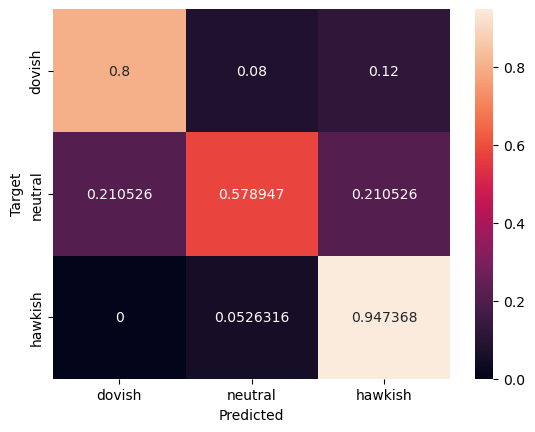

In [109]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['dovish', 'neutral', 'hawkish']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)